In [18]:
# Imports 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Q2Mod import aggregate
import EoN
from scipy.sparse.linalg import eigsh
from random import sample
from tqdm import tqdm 
from random import choice

In [23]:
# Unpack pickle data
G = pd.read_pickle('networks.pkl')

# Initial Parameters
rho = 1
g, b = 0.16, 0.01
maxTime = 100
maxIter = 100

H = aggregate(G, rho)
Gref = H.copy()
len(H.nodes())

11492

In [24]:
# Simulating SIS model on the aggregated network

def SIS(G, b, g):
    # dfs = []
    # for iter in range(maxIter):
    #     data = pd.DataFrame({'Time':[], 'Susceptible':[], 'Infected':[]})

    #     # Simulate SIS model using EoN with node 1 infected
    #     data['Time'], data['Susceptible'], data['Infected'] = EoN.fast_SIS(G, b, g, initial_infecteds = list(G.nodes())[0], tmax = maxTime)
    #     dfs.append(data)
    # averages = pd.concat([each.stack() for each in dfs],axis=1)\
    #             .apply(lambda x:x.mean(),axis=1)\
    #             .unstack()

    # # plt.plot(averages['Time'], averages['Susceptible'], label = 'Susceptible')
    # # plt.plot(averages['Time'], averages['Infected'], label = 'Infected')
    # # plt.legend()
    # # plt.savefig(f'Q-2.4.SIS_On_network_with_b={b}_g={g}.png')
    # # plt.show()
    # return averages

    dt = pd.DataFrame({'Time':[], 'Susceptible':[], 'Infected':[]})
    times = np.linspace(0, maxTime, 101)
    So = np.zeros(len(times))
    Io = np.zeros(len(times))
    for iter in tqdm(range(maxIter)):
        t, S, I = EoN.fast_SIS(G, b, g, initial_infecteds=choice(list(G.nodes())))
        Sn, In = EoN.subsample(times, t, S, I)
        So += Sn
        Io += In
    dt['Susceptible'] = So/float(maxIter)
    dt['Infected'] = Io/float(maxIter)
    dt['Time'] = times

    return dt   
    
    

In [25]:
# Strength of the infection based on SIS is s = \lambda * (\beta / \gamma)

# Pandas dataframe to store the results
df = pd.DataFrame({'Strength of Infection':[], 'Nodes Removed':[]})
# Counter for the number of nodes removed
ctr = 0
# Set an eigens numpy array
eigens = eigsh(nx.adjacency_matrix(H).asfptype(), k=1, which='LM')[0]
Ga = H.copy()
Gesus = []

while np.amin(eigens)*b/g > 1:
    Gb = Ga.copy()
    # Find the node with largest degree
    maxDeg = max(H.degree, key=lambda x: x[1])[0]
    # Remove the node with largest degree
    H.remove_node(maxDeg)
    # Reflect change in the counter
    ctr+=1
    # Get Eigen value of the new network
    eigen = eigsh(nx.adjacency_matrix(H).asfptype(), k=1, which='LM')[0]
    eigens = np.append(eigens, eigen)
    # Append the results to the dataframe
    df = df.append({'Strength of Infection': np.amin(eigens)*b/g, 'Nodes Removed': ctr}, ignore_index=True)
    Ga = H.copy()
    Gesus.append(Ga)

/tmp/ipykernel_474/1181668880.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigens = eigsh(nx.adjacency_matrix(H).asfptype(), k=1, which='LM')[0]
/tmp/ipykernel_474/1181668880.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigen = eigsh(nx.adjacency_matrix(H).asfptype(), k=1, which='LM')[0]
/tmp/ipykernel_474/1181668880.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Strength of Infection': np.amin(eigens)*b/g, 'Nodes Removed': ctr}, ignore_index=True)
/tmp/ipykernel_474/1181668880.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigen = eigsh(nx.adjacency_matrix(H).asfptype(), k=1, which='LM')[0]
/tmp/ipykernel_474/1181668880.py:24: FutureWarning: The frame.append method is deprecated and 

100%|██████████| 100/100 [00:00<00:00, 3853.39it/s]


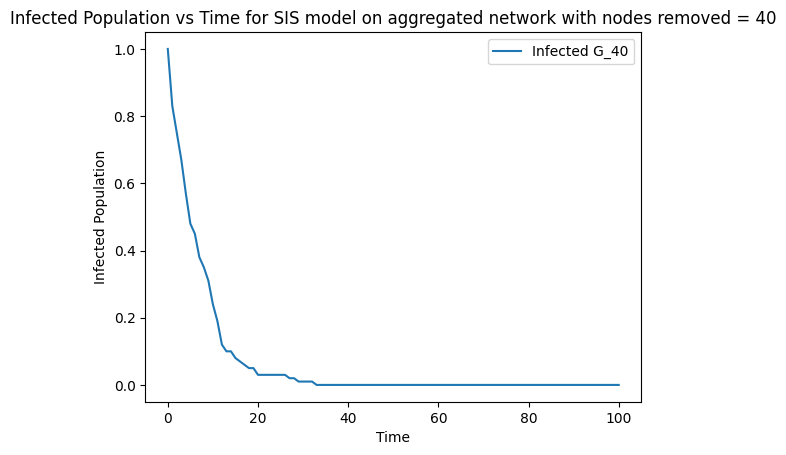

100%|██████████| 100/100 [00:00<00:00, 4480.47it/s]


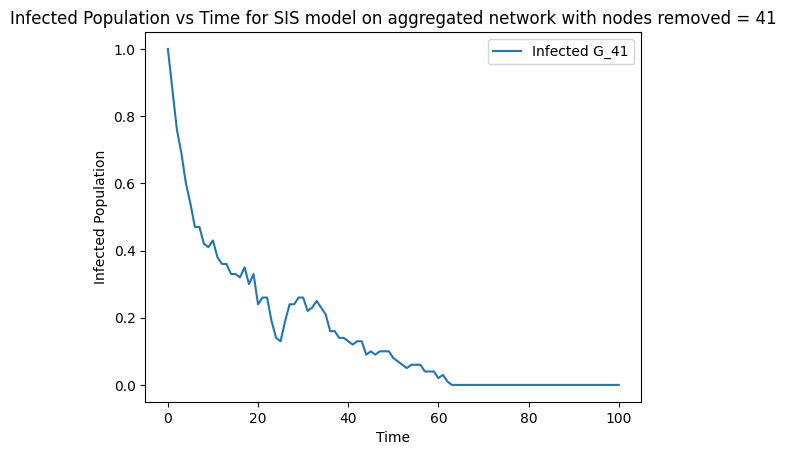

100%|██████████| 100/100 [00:00<00:00, 3629.95it/s]


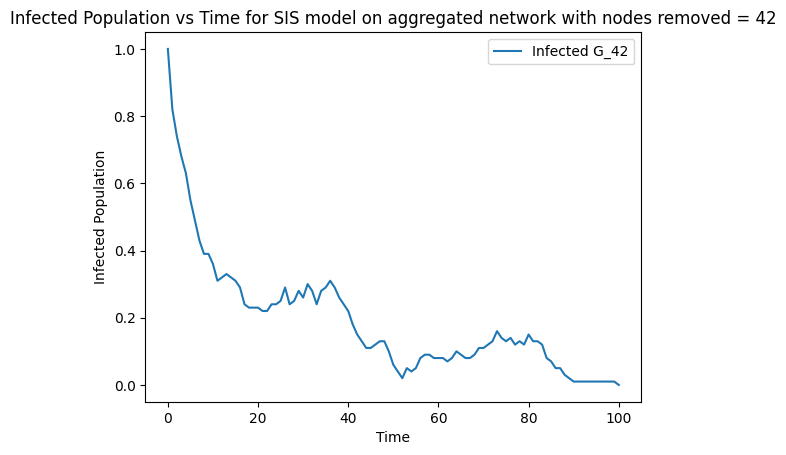

In [26]:
for Gr in Gesus[-3:]:
    res = SIS(Gr, b, g)
    # Plot the infected populations versus time for the variable res
    plt.plot(res['Time'], res['Infected'], label = f'Infected G_{len(Gref.nodes()) - len(Gr.nodes())}')    
    plt.xlabel('Time')
    plt.ylabel('Infected Population')
    plt.title(f'Infected Population vs Time for SIS model on aggregated network with nodes removed = {len(Gref.nodes()) - len(Gr.nodes())}')
    plt.legend()
    plt.savefig(f'Q-2.4.SIS_NodesRemoved={len(Gref.nodes()) - len(Gr.nodes())}_b={b}_g={g}.png')
    plt.show()